<a href="https://colab.research.google.com/github/kyhofer/type-1-simulation/blob/master/Type_1_model_EKF_discrete_time_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required import functions for code.
Will also require an excel contain real BG values, carb and insulin intake

In [ ]:
#import functions required
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!pip install git+https://github.com/florisvb/pyEKF.git
#import ekf

In [ ]:
#EKF
class ExtendedKalmanFilter:
    def __init__(self, process_function, measurement_function, state_transition_jacobian, measurement_jacobian,
                 initial_state_mean, initial_state_covariance, process_noise_covariance, measurement_noise_covariance):
        self.process_function = process_function
        self.measurement_function = measurement_function
        self.state_transition_jacobian = state_transition_jacobian
        self.measurement_jacobian = measurement_jacobian
        self.state_mean = initial_state_mean
        self.state_covariance = initial_state_covariance
        self.Q = process_noise_covariance
        self.R = measurement_noise_covariance

    def predict(self, control_input):
        # Predict the next state
        predicted_state_mean = self.process_function(self.state_mean, control_input)
        predicted_state_covariance = np.dot(np.dot(self.state_transition_jacobian(self.state_mean, control_input),
                                                   self.state_covariance),
                                             self.state_transition_jacobian(self.state_mean, control_input).T) + self.Q

        self.state_mean = predicted_state_mean
        self.state_covariance = predicted_state_covariance

    def update(self, measurement):
        # Measurement update
        predicted_measurement = self.measurement_function(self.state_mean)
        innovation = measurement - predicted_measurement
        innovation_covariance = np.dot(np.dot(self.measurement_jacobian(self.state_mean),
                                               self.state_covariance),
                                        self.measurement_jacobian(self.state_mean).T) + self.R
        kalman_gain = np.dot(np.dot(self.state_covariance, self.measurement_jacobian(self.state_mean).T),
                             np.linalg.inv(innovation_covariance))

        # Update state estimate
        self.state_mean += np.dot(kalman_gain, innovation)
        self.state_covariance = np.dot(np.eye(len(self.state_mean)) - np.dot(kalman_gain,
                                                                             self.measurement_jacobian(self.state_mean)),
                                       self.state_covariance)
        #Ensure that state_mean contains single values
        self.state_mean = np.ravel(self.state_mean)


In [ ]:
# Define the simplified diabetes model
def diabetes_model(state, control_input):
    G = state[0]
    I = state[1]
    G_in, I_in = control_input
    G_n1 = G + (G_in - alpha * G - beta * G * I) * dt
    I_n1 = I + (I_in + C * G - (D * I) / (E + I)) * dt
    return [G_n1, I_n1]


In [ ]:
# Define Jacobian of state transition function
def state_transition_jacobian(state, control_input):
    G = state[0]
    I = state[1]
    G_in, I_in = control_input
    G_in = k1 * u1
    I_in = k2 * u2
    dg_dG = 1 - alpha * dt - beta * dt * I
    dg_dI = -beta * dt * G
    di_dG = C * dt - (D * dt * I) / (E + I) ** 2
    di_dI = (C * dt * (E + I) - D * dt) / (E + I) ** 2
    return np.array([[dg_dG, dg_dI], [di_dG, di_dI]])


have access to actual measured blood glucose values

In [ ]:
# Define measurement function
def measurement_function(state):
    return state[0]  # Only measure blood glucose


# Define Jacobian of measurement function
def measurement_jacobian(state):
    return np.array([[1, 0]])


importing values from excel.
define input values for diabetes model and setting initial conditions

In [ ]:

# Read real data from Excel
excel_file = "BG_data.xlsx"
data_df = pd.read_excel(excel_file)
real_bg_data = data_df["BloodGlucose"].values

insulin_data = data_df["Insulin"].values
carbohydrate_data = data_df["Carbohydrates"].values

# Simulation parameters a,b,c,d,e values from literature [source 9]
E = 2300  # Half saturation value
D = 1500  # Max insulin clearance rate
C = .2298  # Insulin secretion rate
alpha = .00002  # Independent insulin rate
beta = .00075919  # Dependent insulin rate
dt = .01  # Discrete time step
k1 = 1
k2 = 1
# Time vector
t = np.linspace(0, 24,len(real_bg_data))  # Assuming 24 hours of data

# Initial conditions
G_initial = 159  # Initial blood glucose level
I_initial = 0  # Initial insulin concentration


In [ ]:
# Initialize EKF
initial_state_mean = np.array([G_initial, I_initial])
initial_state_covariance = np.eye(2) * 1
process_noise_variance_G = 1e8  # Low confidence in actual carbohyrate intake
process_noise_variance_I = 1e-6  # High confidence in actual I intake
Q = np.diag([process_noise_variance_G, process_noise_variance_I])
measurement_noise_covariance = np.eye(1) * 1e6
ekf = ExtendedKalmanFilter(diabetes_model, measurement_function, state_transition_jacobian,
                           measurement_jacobian, initial_state_mean, initial_state_covariance,
                           Q, measurement_noise_covariance)

# Initialize arrays to store results
G_out = np.zeros_like(t)
I_out = np.zeros_like(t)
state = initial_state_mean


In [ ]:
# Simulation loop
for i in range(len(t)):
    # Get insulin and carbohydrate values from the Excel data
    u1 = carbohydrate_data[i]
    u2 = insulin_data[i]

    # Predict the next state using the EKF with control inputs
    ekf.predict([u1, u2])

    # Update the state estimate using the blood glucose measurement
    ekf.update(real_bg_data[i])

    # Save the results
    G_out[i] = ekf.state_mean[0]
    I_out[i] = ekf.state_mean[1]


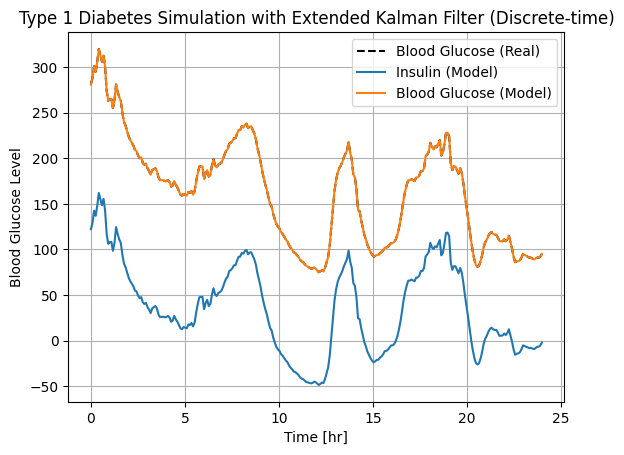

In [ ]:
# Plot the results
plt.plot(t, real_bg_data,'--',color = 'k', label='Blood Glucose (Real)')
plt.plot(t, I_out,'-', label='Insulin (Model)')
plt.plot(t, G_out,'-', label='Blood Glucose (Model)')

plt.xlabel('Time [hr]')
plt.ylabel('Blood Glucose Level')
plt.title('Type 1 Diabetes Simulation with Extended Kalman Filter (Discrete-time)')
plt.legend()
plt.grid(True)

plt.show()